In [1]:
import os
from tqdm.notebook import tqdm
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Existing dataset dir
data_dir = './data/'

# Existing plots dir
plots_dir = data_dir+'/plots/'
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


In [3]:
colors = {'red': '#ee443a', 'blue': '#42bbf1', 'dark_blue': '#1a4fec',
          'green': '#50be61', 'grey': '#b7b7b7', 'orange': '#f28222', 'purple': '#6e18ee', 'brown': '#a65628', 'pink': '#ef4793',
          'yellow': '#f8c94c', 'black': '#000000', 'white': '#ffffff', 'light_blue': '#a6cee3', 'light_green': '#b2df8a',
          'light_grey': '#999999', 'light_orange': '#fdbf6f', 'light_purple': '#cab2d6', 'light_brown': '#ffff99', 'light_pink': '#1f78b4',
          'light_yellow': '#fb9a99', 'light_black': '#e31a1c', 'light_white': '#33a02c', 'gold': '#ff7f00', 'silver': '#b2df8a'}


plot_settings = {
    'arbitrum': {'color': colors['blue'],   'label': 'Arbitrum', 'style': 'solid', 'width': 4, 'marker_symbol': 'circle'},
    'base': {'color': colors['red'],        'label': 'Base', 'style': 'dash', 'width': 3.5, 'marker_symbol': 'diamond'},
    'ethereum': {'color': colors['green'],  'label': 'Ethereum', 'style': 'dot', 'width': 3, 'marker_symbol': 'square'},
    'optimism': {'color': colors['grey'],   'label': 'Optimism', 'style': 'dashdot', 'width': 2.5, 'marker_symbol': 'triangle-up'},
    'zksync': {'color': colors['pink'],     'label': 'zkSync', 'style': 'solid', 'width': 2, 'marker_symbol': 'cross'},
    'arbitrum2': {'color': colors['brown'],    'label': 'Fantom', 'style': 'dash', 'width': 1.5, 'marker_symbol': 'star'},
}

file_settings = {
    'ethereum': {  'nr': '1', 'file_name': './data/mav-ethereum-Uniswap-v3-WETH-USDC.paraquet' , 'output_file': './data/mav2-ethereum-Uniswap-v3-WETH-USDC.paraquet' },
    'arbitrum': {  'nr': '2', 'file_name': './data/mav-arbitrum-Uniswap-v3-WETH-USDC.paraquet' , 'output_file': './data/mav2-arbitrum-Uniswap-v3-WETH-USDC.paraquet'},
    'arbitrum2': { 'nr': '3', 'file_name': './data/mav-arbitrum-Uniswap-v3-WETH-USDCe.paraquet', 'output_file': './data/mav2-arbitrum-Uniswap-v3-WETH-USDCe.paraquet'},
    'base': {      'nr': '4', 'file_name': './data/mav-base-Uniswap-v3-WETH-USDC.paraquet'     , 'output_file': './data/mav2-base-Uniswap-v3-WETH-USDC.paraquet'},
    'optimism': {  'nr': '5', 'file_name': './data/mav-optimism-Uniswap-v3-WETH-USDC.paraquet' , 'output_file': './data/mav2-optimism-Uniswap-v3-WETH-USDC.paraquet'},
    'zksync': {    'nr': '6', 'file_name': './data/mav-zksync-Uniswap-v3-WETH-USDC.paraquet'   , 'output_file': './data/mav2-zksync-Uniswap-v3-WETH-USDC.paraquet' } ,
}

columns = ["Binance","Ethereum","Arbitrum","Arbitrum(e)","Base", "Optimism(e)", "zkSync(e)"]
price_diff_matrix = np.zeros((7, 7))
MAV_matrix = np.zeros((7, 7))

In [4]:

for key0, value0 in file_settings.items():
    file_name0 = value0['file_name']
    nr0 = int(value0['nr'])

    #Binance
    nr1 = 0 
    swaps_df0 = pl.scan_parquet(file_name0).collect(streaming=True)
    price_diff = abs(swaps_df0['r_price_diff']).mean()
    price_diff_matrix[0, nr0] = price_diff
    price_diff_matrix[nr0, 0] = price_diff
    MAV = swaps_df0['max_MAV_USD'].sum()
    MAV_matrix[nr1, nr0] = MAV
    MAV_matrix[nr0, nr1] = MAV
    del swaps_df0

    print("loop: " + value0['nr'])

    #start calculations
    for key1, value1 in file_settings.items():

        swaps_df0 = pl.scan_parquet(file_name0).collect(streaming=True)

        suffix = "_" + value1['nr']
        nr1 = int(value1['nr'])

        if (nr0 != nr1) :
            print(suffix)
            file_name1 = value1['file_name']

            #swaps_df1 = pl.scan_parquet(file_name1).collect(streaming=True)
            swaps_df_full = pl.scan_parquet(file_name1).collect(streaming=True)
            swaps_df_full = swaps_df0.join(swaps_df_full, on='block_timestamp', how="outer", suffix=suffix)
            #del swaps_df1

            swaps_df_full = swaps_df_full.with_columns(
                pl.when(pl.col("block_timestamp").is_not_null())
                .then(pl.col("block_timestamp") )
                .otherwise(pl.col("block_timestamp"+suffix) )
                .alias("block_timestamp_X")
            )
            swaps_df_full = swaps_df_full.sort("block_timestamp_X")

            swaps_df_full = swaps_df_full.with_columns(pl.col("spot_price"+suffix).fill_null(strategy="forward"))
            swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_USD"+suffix).fill_null(strategy="forward"))
            swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_ETH"+suffix).fill_null(strategy="forward"))
            swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_total_USD"+suffix).fill_null(strategy="forward"))

            swaps_df_full = swaps_df_full.select("block_timestamp", "spot_price"+suffix, "reserve_USD"+suffix, "reserve_ETH"+suffix, "reserve_total_USD"+suffix)
            swaps_df0 = swaps_df0.join(swaps_df_full, on = "block_timestamp", how="left")

            swaps_df0 = swaps_df0.with_columns(
                ((pl.col("spot_price"+suffix) - pl.col("spot_price")).abs() / pl.col("spot_price")).alias("r_price_diff" + suffix)
            )
            price_diff = swaps_df0["r_price_diff" + suffix].mean()
            price_diff_matrix[nr1, nr0] = price_diff

            del swaps_df_full
        #swaps_df0.write_parquet(output_file0)
        del swaps_df0
        


loop: 1
_2
_3
_4
_5
_6
loop: 2
_1
_3
_4
_5
_6
loop: 3
_1
_2
_4
_5
_6
loop: 4
_1
_2
_3
_5
_6
loop: 5
_1
_2
_3
_4
_6
loop: 6
_1
_2
_3
_4
_5


In [5]:
print(price_diff_matrix)

[[0.         0.00049962 0.00032142 0.00035561 0.00073072 0.00046957
  0.00224491]
 [0.00049962 0.         0.0004801  0.00073781 0.00076848 0.00061327
  0.00206885]
 [0.00032142 0.00076196 0.         0.00023403 0.00062372 0.00043942
  0.00244538]
 [0.00035561 0.00104121 0.00019788 0.         0.00078242 0.00048941
  0.00246964]
 [0.00073072 0.00114328 0.00070626 0.00117823 0.         0.00122837
  0.00196995]
 [0.00046957 0.00099964 0.00033758 0.00054506 0.00071345 0.
  0.00216192]
 [0.00224491 0.00257002 0.00225378 0.00287346 0.00212185 0.00298001
  0.        ]]


In [6]:
print(MAV_matrix)

[[0.00000000e+00 5.24878305e+07 2.69939460e+06 2.70694782e+06
  1.29429131e+06 6.90855916e+05 2.01103805e+04]
 [5.24878305e+07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.69939460e+06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.70694782e+06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.29429131e+06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.90855916e+05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.01103805e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]


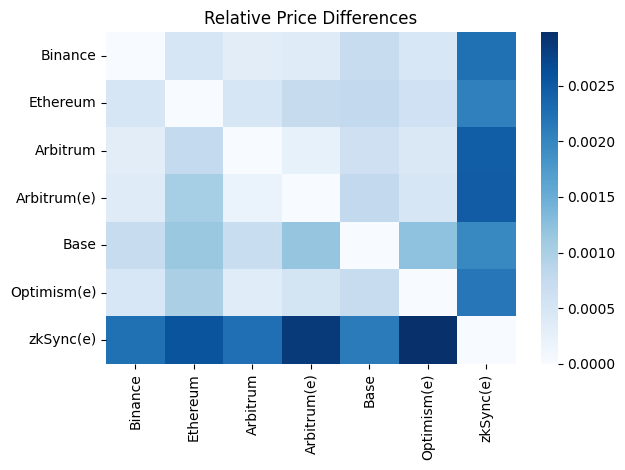

In [7]:

# Default heatmap
p1 = sns.heatmap(price_diff_matrix, cmap="Blues")
p1.set_xticklabels(columns, rotation=90)
p1.set_yticklabels(columns, rotation=0)

p1.set_title("Relative Price Differences")

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("heatmap_price.pdf", format="pdf")

# Show the plot (optional, can be omitted if not needed)
plt.show()

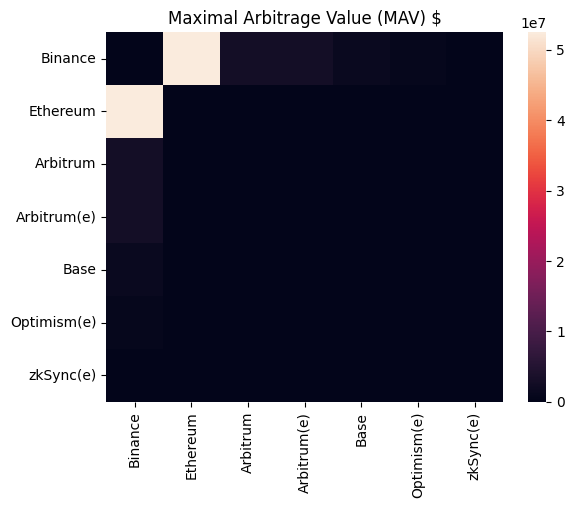

In [8]:


# Default heatmap
p1 = sns.heatmap(MAV_matrix)
p1.set_xticklabels(columns, rotation=90)
p1.set_yticklabels(columns, rotation=0)

p1.set_title("Maximal Arbitrage Value (MAV) $")

# Save the plot as a PDF file
plt.savefig("heatmap_MAV.pdf", format="pdf")

# Show the plot (optional, can be omitted if not needed)
plt.show()

In [9]:
faf adfas

for key, value in file_settings.items():
    file_name = value['output_file']
    nr = int(value['nr'])

    swaps_df = pl.scan_parquet(file_name).collect(streaming=True)

    price_diff = abs(swaps_df['r_price_diff']).mean()
    price_diff_matrix[0, nr] = price_diff
    price_diff_matrix[nr, 0] = price_diff

    MAV = swaps_df['max_MAV_USD'].sum()
    MAV_matrix[0, nr] = MAV
    MAV_matrix[nr, 0] = MAV

    print("loop: " + value['nr'])

    for key1, value1 in file_settings.items():
        suffix = "_" + value1['nr']
        nr1 = int(value1['nr'])
        if (nr != nr1) :
            print(suffix)
            swaps_df = swaps_df.with_columns(
                ((pl.col("spot_price"+suffix) - pl.col("spot_price")).abs() / pl.col("spot_price")).alias("r_price_diff" + suffix)
            )
            price_diff = swaps_df["r_price_diff" + suffix].mean()
            price_diff_matrix[nr1, nr] = price_diff

    del swaps_df


SyntaxError: invalid syntax (843463190.py, line 1)